In [ ]:
! pip install scikeras
! pip install git+https://github.com/modAL-python/modAL.git

import os
import keras
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from modAL.models import ActiveLearner
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from modAL.uncertainty import entropy_sampling
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Input, GlobalAveragePooling2D

In [2]:
def Load_Images(main_folder_path):
    images = []
    labels = []
    label_mapping = {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
    
    for label in os.listdir(main_folder_path):
        label_path = os.path.join(main_folder_path, label)
        label_value = label_mapping[label]
        
        for filename in os.listdir(label_path):
            image_path = os.path.join(label_path, filename)
            image = load_img(image_path, target_size=(224, 224))
            arrayed_image = img_to_array(image)
            normalized_image = arrayed_image / 255.0
            images.append(normalized_image)
            labels.append(label_value)
                
    return np.array(images), np.array(labels)

In [3]:
Flower_Images, Flower_Labels = Load_Images('../input/flowers')

In [4]:
X_train, X_test_split, Y_train, Y_test_split = train_test_split(Flower_Images, Flower_Labels, test_size=0.5, random_state=42)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_test_split, Y_test_split, test_size=0.5, random_state=42)

In [5]:
# assemble initial data
n_initial = 658
np.random.seed(2)
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial = X_train[initial_idx]
Y_initial = Y_train[initial_idx]

# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)
Y_pool = np.delete(Y_train, initial_idx, axis=0)

In [ ]:
Input_Layer = Input(shape=(224, 224, 3))
MobileNet_Model = keras.applications.MobileNet(
                                                alpha=1.0,
                                                depth_multiplier=1,
                                                dropout=0.001,
                                                include_top=False,
                                                weights="imagenet",
                                                input_tensor=Input_Layer
                                               )
MobileNet_Model.trainable = False

Pooled_output = GlobalAveragePooling2D()(MobileNet_Model.output)

mobile_model = Model(inputs = MobileNet_Model.input, outputs = Pooled_output)

In [7]:
def plotting_scores(f1_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(f1_scores)), f1_scores, marker='o')
    plt.xlabel('Active Learning Cycle')
    plt.ylabel('F1Score')
    plt.title(f'F1 Score Improvment using SVM Classifier')
    plt.grid(True)
    plt.show()

In [8]:
def compute_confusion_matrix(Y_test, y_pred, color):
    
    cm = confusion_matrix(Y_test, y_pred)

    class_names = ["Daisy", "Dandelion", "Rose", "Sunflower", "Tulip"]

    sns.heatmap(cm, 
                annot=True,
                cmap = color,
                fmt='g', 
                xticklabels=class_names,
                yticklabels=class_names)
    plt.ylabel('Prediction',fontsize=13)
    plt.xlabel('Actual',fontsize=13)
    plt.title(f'Confusion Matrix After Active Learning', fontsize=14)
    plt.show()

In [9]:
pca = PCA(n_components=2)

In [10]:
classifier = SVC(kernel='rbf', probability=True)

### **Initial Data = 682**

### **Cycles = 10**

### **Instances = 5**

In [ ]:
X_initial_features = mobile_model.predict(X_initial)
X_initial_features_pca = pca.fit_transform(X_initial_features)

In [12]:
# initialize ActiveLearner
learner = ActiveLearner(
                         estimator = classifier,
                         query_strategy = entropy_sampling,
                         X_training = X_initial_features_pca, y_training = Y_initial
                       )
accuracy = learner.score(X_initial_features_pca, Y_initial)
print("Accuracy on initial data: ", accuracy)

Accuracy on initial data:  0.5674486803519062


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step


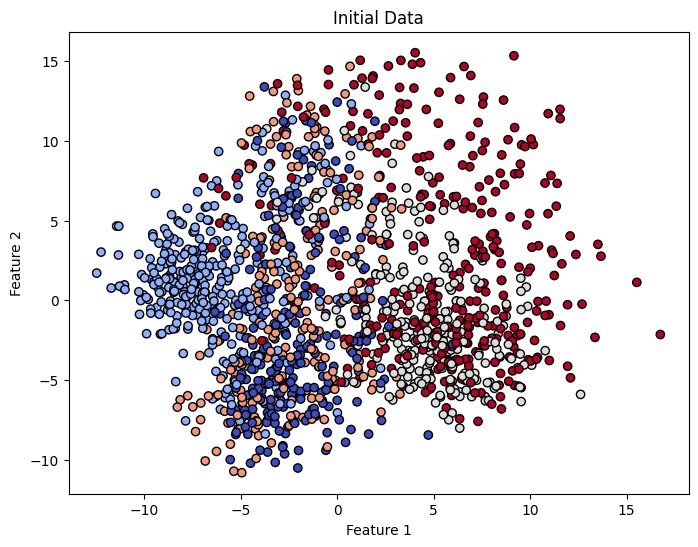

In [13]:
X_features_pca = pca.transform(mobile_model.predict(X_pool))
plt.figure(figsize=(8, 6))
plt.scatter(X_features_pca[:, 0], X_features_pca[:, 1], c=Y_pool, cmap='coolwarm', edgecolors='k')
plt.title('Initial Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step
F1-score (Micro) for iteration 1: 0.5772025836410366


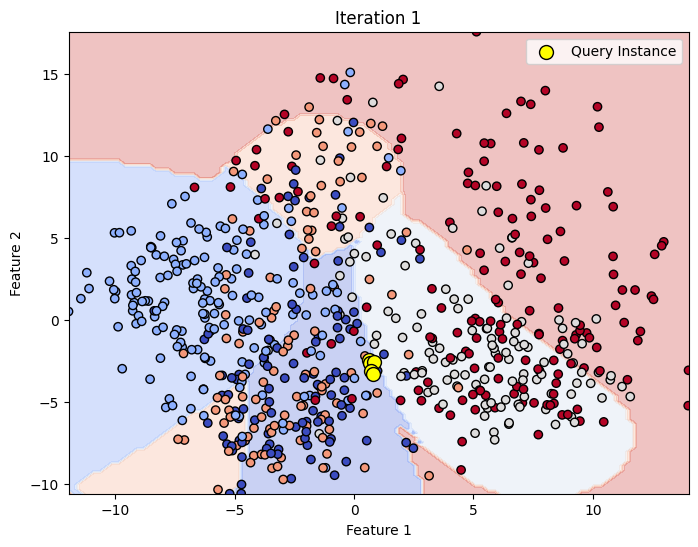

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
F1-score (Micro) for iteration 2: 0.5747574454091654


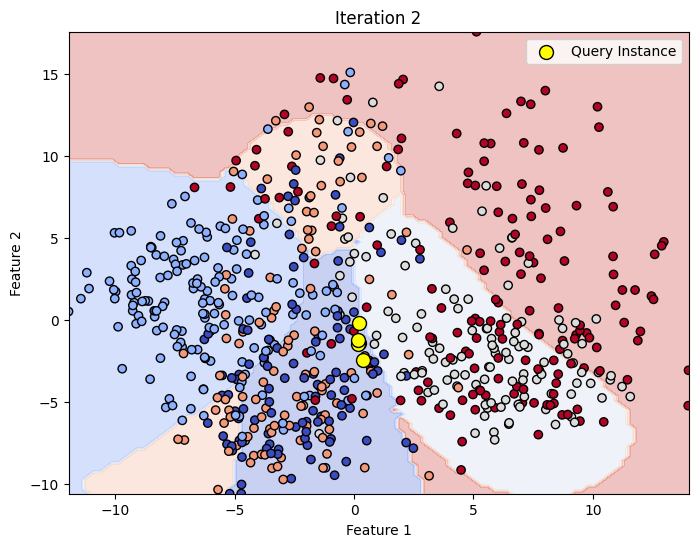

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
F1-score (Micro) for iteration 3: 0.5787074727470258


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
F1-score (Micro) for iteration 4: 0.5760093303341438


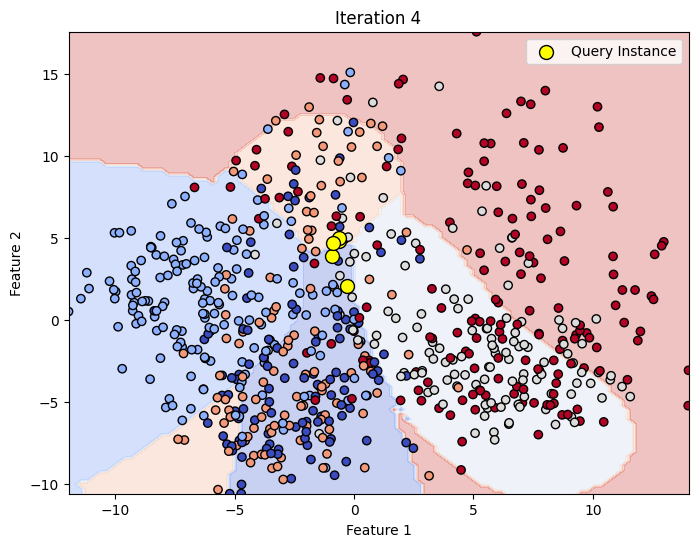

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
F1-score (Micro) for iteration 5: 0.5817540980766075


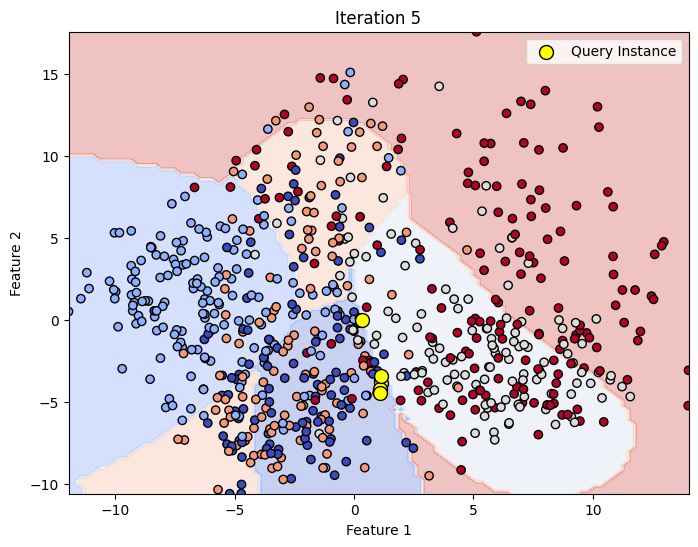

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
F1-score (Micro) for iteration 6: 0.5822189439874835


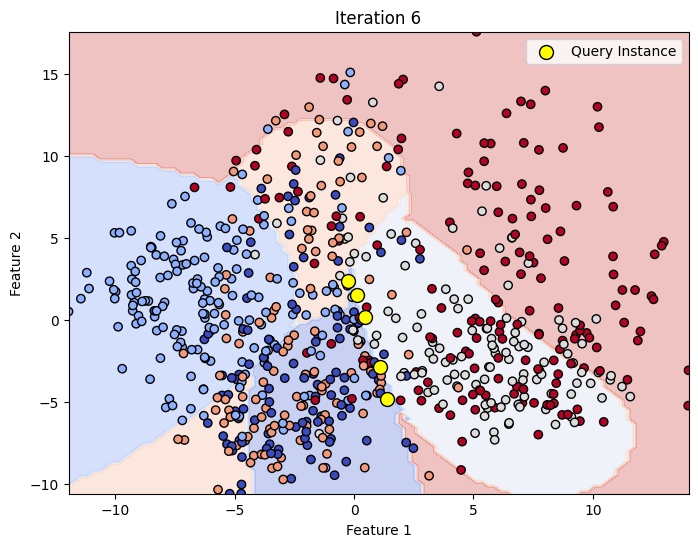

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
F1-score (Micro) for iteration 7: 0.5827925112864932


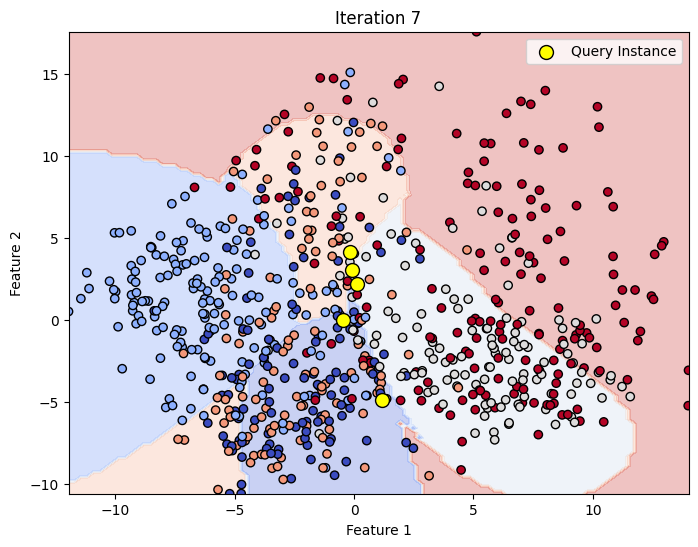

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
F1-score (Micro) for iteration 8: 0.5828653579706353


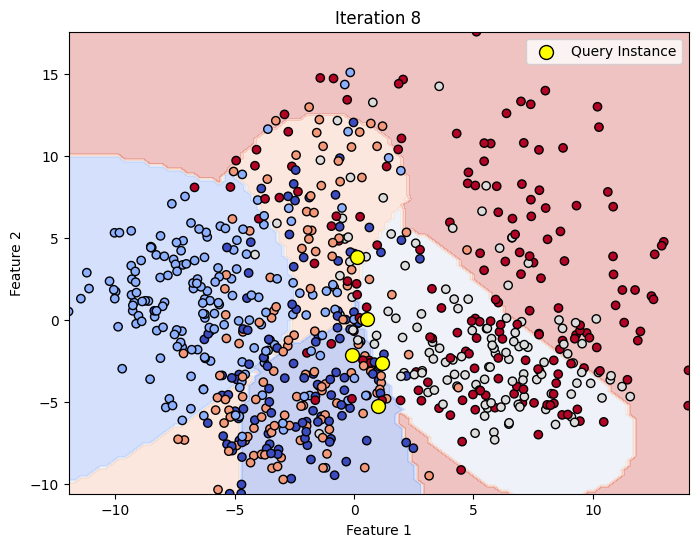

45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
F1-score (Micro) for iteration 9: 0.5828285301368873


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
F1-score (Micro) for iteration 10: 0.5794582254015018


In [14]:
n_queries = 10
f1_scores = []
Training_Data = X_initial_features_pca
Training_Labels = Y_initial

for idx in range(n_queries):
    plt.figure(figsize=(8, 6))
    
    X_pool_features_pca = pca.transform(mobile_model.predict(X_pool))
    
    # Fit the classifier on pool data
    learner.estimator.fit(Training_Data, Training_Labels)
    
    # Plot the decision boundary
    xx, yy = np.meshgrid(np.linspace(Training_Data[:, 0].min(), Training_Data[:, 0].max(), 100),
                         np.linspace(Training_Data[:, 1].min(), Training_Data[:, 1].max(), 100))
    Z = learner.estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    
    # Plot the data points
    plt.scatter(Training_Data[:, 0], Training_Data[:, 1], c=Training_Labels, cmap='coolwarm', edgecolors='k')
    
    # Query the next instances
    query_idx, query_instance = learner.query(X_pool_features_pca, n_instances=5)
    
    Training_Data = np.concatenate((Training_Data, X_pool_features_pca[query_idx]), axis=0)
    Training_Labels = np.concatenate((Training_Labels, Y_pool[query_idx]), axis=0)
    
    X_validate_features = pca.transform(mobile_model.predict(X_validate))
    y_pred = learner.estimator.predict(X_validate_features)
    
    f1_micro = f1_score(Y_validate, y_pred, average='weighted')
    f1_scores.append(f1_micro)
    print(f"F1-score (Micro) for iteration {idx+1}:", f1_micro)
    
    # Highlight the queried instances
    plt.scatter(X_pool_features_pca[query_idx][:, 0], X_pool_features_pca[query_idx][:, 1], c='yellow', s=100, edgecolors='k', label='Query Instance')

    # Remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    Y_pool = np.delete(Y_pool, query_idx, axis=0)
    
    plt.title(f'Iteration {idx+1}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

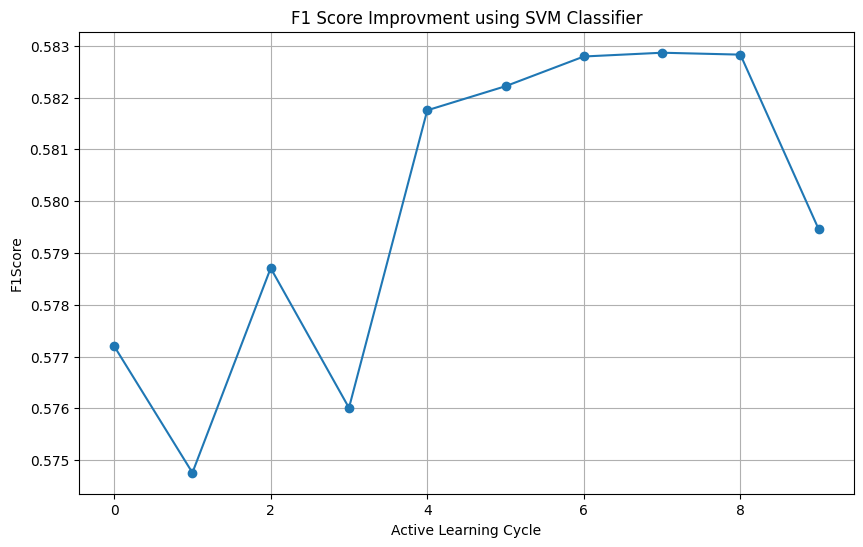

In [15]:
plotting_scores(f1_scores)

In [16]:
X_test_features = mobile_model.predict(X_test)
X_test_features_pca = pca.fit_transform(X_test_features)

score = learner.score(X_test_features_pca, Y_test)
print('Testing Accuracy After Active Learning:', score)

Y_pred = learner.predict(X_test_features_pca)
f1 = f1_score(Y_test, Y_pred, average='weighted')
print('F1 Score on Test Data After Active Learning:', f1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step
Testing Accuracy After Active Learning: 0.20092592592592592
F1 Score on Test Data After Active Learning: 0.20317497984324864


In [17]:
compute_confusion_matrix(Y_test, Y_pred,'turbo')

### **Initial Data = 658**

### **Cycles = 10**

### **Instances = 150**

In [ ]:
X_initial_features = mobile_model.predict(X_initial)
X_initial_features_pca = pca.fit_transform(X_initial_features)

In [12]:
# initialize ActiveLearner
learner = ActiveLearner(
                         estimator = classifier,
                         query_strategy = entropy_sampling,
                         X_training = X_initial_features_pca, y_training = Y_initial
                       )
accuracy = learner.score(X_initial_features_pca, Y_initial)
print("Accuracy on initial data: ", accuracy)

Accuracy on initial data:  0.5729483282674772


In [13]:
X_features_pca = pca.transform(mobile_model.predict(X_pool))
plt.figure(figsize=(8, 6))
plt.scatter(X_features_pca[:, 0], X_features_pca[:, 1], c=Y_pool, cmap='coolwarm', edgecolors='k')
plt.title('Initial Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step
F1-score (Micro) for iteration 1: 0.5811171540479987


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
F1-score (Micro) for iteration 2: 0.5789797236619039


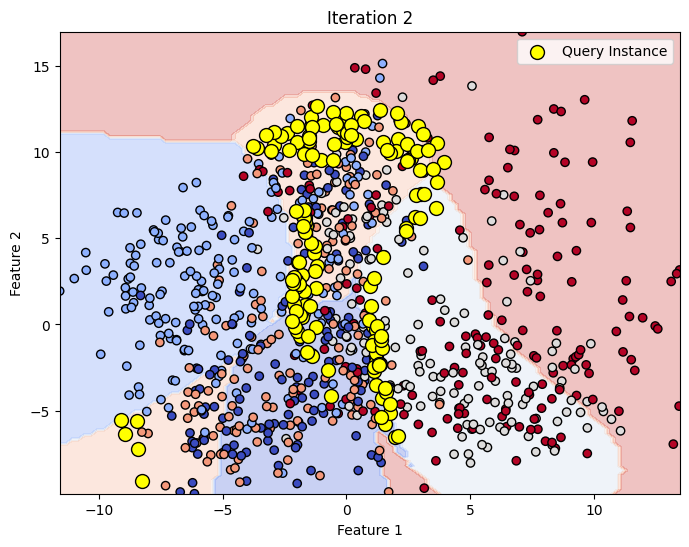

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 3: 0.5882365559017909


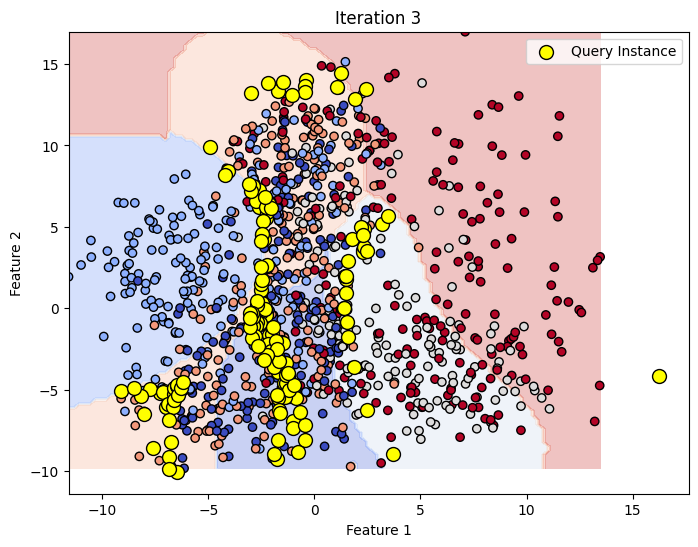

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
F1-score (Micro) for iteration 4: 0.582493227421592


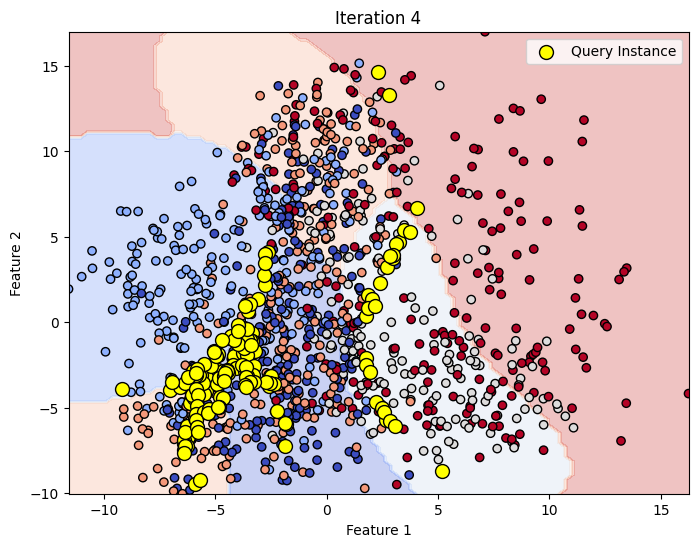

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 5: 0.5855636625309658


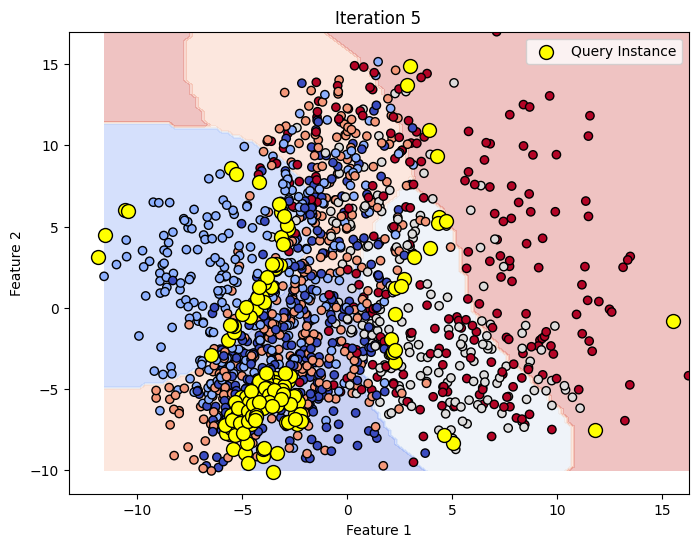

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
F1-score (Micro) for iteration 6: 0.5794913664736594


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 7: 0.578812640703465


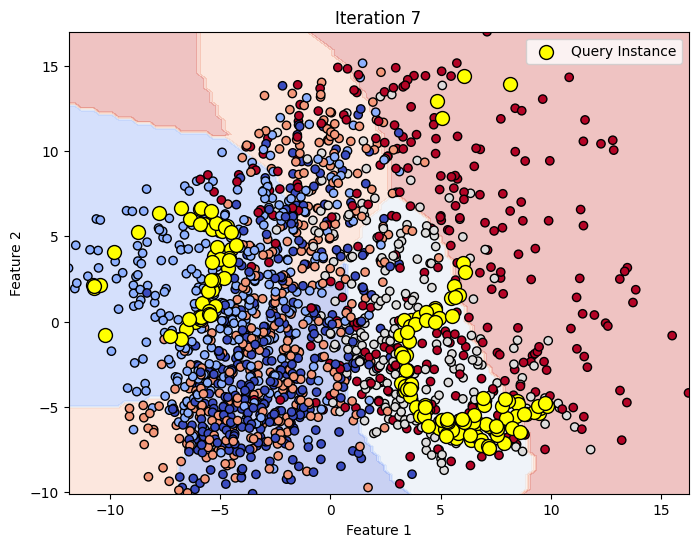

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 8: 0.5764770804830281


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
F1-score (Micro) for iteration 9: 0.572989194949546


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 974ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
F1-score (Micro) for iteration 10: 0.5724252060188929


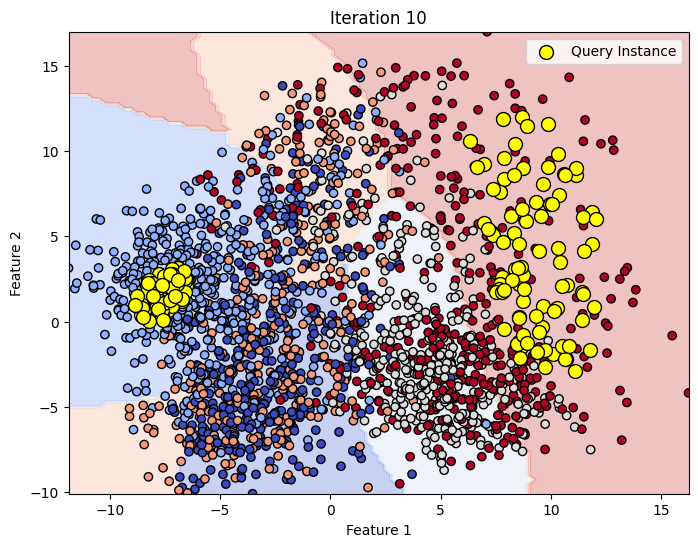

In [14]:
n_queries = 10
f1_scores = []
Training_Data = X_initial_features_pca
Training_Labels = Y_initial

for idx in range(n_queries):
    plt.figure(figsize=(8, 6))
    
    X_pool_features_pca = pca.transform(mobile_model.predict(X_pool))
    
    # Fit the classifier on pool data
    learner.estimator.fit(Training_Data, Training_Labels)
    
    # Plot the decision boundary
    xx, yy = np.meshgrid(np.linspace(Training_Data[:, 0].min(), Training_Data[:, 0].max(), 100),
                         np.linspace(Training_Data[:, 1].min(), Training_Data[:, 1].max(), 100))
    Z = learner.estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    
    # Plot the data points
    plt.scatter(Training_Data[:, 0], Training_Data[:, 1], c=Training_Labels, cmap='coolwarm', edgecolors='k')
    
    # Query the next instances
    query_idx, query_instance = learner.query(X_pool_features_pca, n_instances=150)
    
    Training_Data = np.concatenate((Training_Data, X_pool_features_pca[query_idx]), axis=0)
    Training_Labels = np.concatenate((Training_Labels, Y_pool[query_idx]), axis=0)
    
    X_validate_features = pca.transform(mobile_model.predict(X_validate))
    y_pred = learner.estimator.predict(X_validate_features)
    
    f1_micro = f1_score(Y_validate, y_pred, average='weighted')
    f1_scores.append(f1_micro)
    print(f"F1-score (Micro) for iteration {idx+1}:", f1_micro)
    
    # Highlight the queried instances
    plt.scatter(X_pool_features_pca[query_idx][:, 0], X_pool_features_pca[query_idx][:, 1], c='yellow', s=100, edgecolors='k', label='Query Instance')

    # Remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    Y_pool = np.delete(Y_pool, query_idx, axis=0)
    
    plt.title(f'Iteration {idx+1}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

In [15]:
plotting_scores(f1_scores)

In [16]:
X_test_features = mobile_model.predict(X_test)
X_test_features_pca = pca.fit_transform(X_test_features)

score = learner.score(X_test_features_pca, Y_test)
print('Testing Accuracy After Active Learning:', score)

Y_pred = learner.predict(X_test_features_pca)
f1 = f1_score(Y_test, Y_pred, average='weighted')
print('F1 Score on Test Data After Active Learning:', f1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Testing Accuracy After Active Learning: 0.18425925925925926
F1 Score on Test Data After Active Learning: 0.17762098799137707


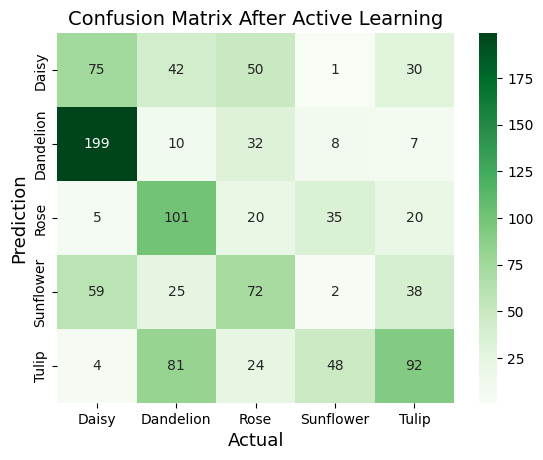

In [23]:
compute_confusion_matrix(Y_test, Y_pred,'Greens')